_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [37]:
train.shape, test.shape

((51916, 17), (17306, 17))

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

#LEAKAGE
Should not use violations.. vi0lations are known POST inspections. which would affect the model


In [43]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [136]:
train['Violations'].value_counts()

38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: 3-COMPARTMENT SINK FAUCET LEAKING. REPAIR SAME.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [0]:
train['Violations'] = train.Violations.str.extract('(\d+)')

In [0]:
features = ['Risk', 'Zip', 'Latitude', 'Longitude', 'Inspection Type']
target = 'Fail'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [156]:
X_train.isnull().sum()

Risk                 12
Zip                  26
Latitude            198
Longitude           198
Inspection Type       1
Violations         9655
dtype: int64

In [157]:
!pip install category_encoders

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce

preprocess = make_pipeline(
    ce.OrdinalEncoder(cols=['Risk','Inspection Type']),
)

X_train = preprocess.fit_transform(train[features])
X_train = pd.DataFrame(X_train, columns=features)
X_train.head()

X_test = preprocess.transform(test[features])
X_test = pd.DataFrame(X_test, columns=features)


### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score


In [164]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators' : [100, 200],
    'max_depth' : [2,3,4],
}

gridsearch = RandomizedSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42),
    param_distributions= param_distributions,
    n_iter=8,
    cv=3,
    scoring='roc_auc',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=8. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   47.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=8, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200], 'max_depth': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [165]:
results = pd.DataFrame(gridsearch.cv_results_)
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,6.980919,0.932431,0.172383,0.019511,200,4,"{'n_estimators': 200, 'max_depth': 4}",0.991381,0.988519,0.989842,0.989914,0.001169,1,0.992329,0.992741,0.992771,0.992614,0.000202
4,3.927590,0.003210,0.097754,0.001231,100,4,"{'n_estimators': 100, 'max_depth': 4}",0.990256,0.987279,0.988959,0.988831,0.001219,2,0.989588,0.990437,0.990454,0.990160,0.000404
3,5.972904,0.034779,0.143305,0.001805,200,3,"{'n_estimators': 200, 'max_depth': 3}",0.989805,0.987328,0.988713,0.988616,0.001013,3,0.989250,0.990122,0.989989,0.989787,0.000384
2,3.019439,0.029577,0.079265,0.003118,100,3,"{'n_estimators': 100, 'max_depth': 3}",0.986317,0.984069,0.985424,0.985270,0.000924,4,0.985052,0.986615,0.985961,0.985876,0.000641
1,4.477507,0.054977,0.107839,0.002139,200,2,"{'n_estimators': 200, 'max_depth': 2}",0.984970,0.981740,0.983467,0.983392,0.001320,5,0.983204,0.984450,0.984062,0.983906,0.000521
0,2.261865,0.015014,0.059720,0.001389,100,2,"{'n_estimators': 100, 'max_depth': 2}",0.979704,0.975415,0.977941,0.977687,0.001760,6,0.977701,0.978383,0.978021,0.978035,0.000278


In [168]:
from sklearn.metrics import roc_auc_score
final = gridsearch.best_estimator_

y_pred_test_proba = final.predict_proba(X_test)[:,1]


test_score = roc_auc_score(y_test, y_pred_test_proba)
print('ROC AUC, with final model, on hold-out-test set:', test_score)

ROC AUC, with final model, on hold-out-test set: 0.6242500508327204


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

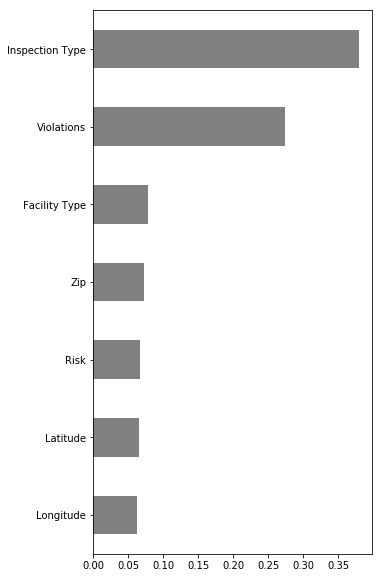

In [99]:
import matplotlib.pyplot as plt

## plotting importance of features
plt.figure(figsize=(5,10)) ## to make it easier to see labels

importances = pd.Series(gridsearch.best_estimator_.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='gray')

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

1) Gradient Descent seeks the local minimum of a function.  For linear regression, Gradient descent is looking to find the right mix of 'thetas' that minimizes the residual squared error.  In other words, it seeks the coefficients that will fit a model best.

2) The learning rate is how fast or slow the gradient descent function will update.  It determines the size of the steps the updating takes when trying to find the local minimum of a function.